In [1]:
import os
import sys
import glob
from collections import defaultdict, Counter
from functools import reduce, partial
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import bootstrap, binom_test
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import cosine, euclidean
from Bio import SeqIO
import tqdm

from pymutspec.draw import plot_mutspec12, plot_mutspec192
from pymutspec.annotation import rev_comp, CodonAnnotation, transcriptor, mutations_summary, calculate_mutspec
from pymutspec.io import read_rates, GenesStates
from pymutspec.constants import possible_sbs192, possible_sbs12

%matplotlib inline

In [183]:
def complete_sbs192_columns(df: pd.DataFrame):
    df = df.copy()
    if len(df.columns) != 192:
        for sbs192 in set(possible_sbs192).difference(df.columns.values):
            df[sbs192] = 0.
    df = df[possible_sbs192]
    return df


def jackknife_spectra_sampling(obs: pd.DataFrame, exp: pd.DataFrame, frac=0.5, n=1000):
    if len(obs.columns) == 192 and (obs.columns == possible_sbs192).all() and (exp.columns == possible_sbs192).all():
        assert obs.index.names == ["RefNode", "AltNode"]
        assert exp.index.names == ["Node"]
        altnodes  = obs.index.get_level_values(1).values
        obs_edges = obs
        freqs_nodes = exp
        obs_edges.index = obs_edges.index.reorder_levels(order=["AltNode", "RefNode"])
        freqs_nodes.index.name = "RefNode"
    else:
        altnodes = obs.AltNode.unique()
        obs_edges = obs.groupby(["AltNode", "RefNode", "Mut"]).ProbaFull.sum().unstack()
        obs_edges = complete_sbs192_columns(obs_edges)
        freqs_nodes = exp.rename(columns={"Node": "RefNode"}).groupby(["RefNode", "Mut"]).Proba.sum().unstack()
        freqs_nodes = complete_sbs192_columns(freqs_nodes)

    edges_sample_size = int(len(altnodes) * frac)
    spectra = []
    for _ in range(n):
        altnodes_sample = np.random.choice(altnodes, edges_sample_size, False)
        obs_sample = obs_edges.loc[altnodes_sample].reset_index(0, drop=True)
        exp_sample = freqs_nodes.loc[obs_sample.index]
        
        obs_sample_cnt = obs_sample.sum()
        exp_sample_cnt = exp_sample.sum()

        assert (obs_sample_cnt.index == exp_sample_cnt.index).all()

        sample_spectra = obs_sample_cnt / exp_sample_cnt
        spectra.append(sample_spectra)

    return pd.DataFrame(spectra).fillna(0.)


def collapse_sbs192(df: pd.DataFrame, to=12):
    assert (df.columns == possible_sbs192).all()
    df = df.copy()
    if to == 12:
        for sbs192 in possible_sbs192:
            sbs12 = sbs192[2:5]
            if sbs12 in df.columns.values:
                df[sbs12] += df[sbs192]
            else:
                df[sbs12] = df[sbs192]

        return df[possible_sbs12]
    else:
        raise NotImplementedError()


def calc_edgewise_spectra(obs: pd.DataFrame, exp: pd.DataFrame, nmtypes_cutoff=16, nobs_cuttof=20, collapse_to_12=False, scale=True, both_12_and_192=False):
    if len(obs.columns) == 192 and (obs.columns == possible_sbs192).all() and (exp.columns == possible_sbs192).all():
        assert obs.index.names == ["RefNode", "AltNode"]
        assert exp.index.names == ["Node"]
        obs_edges = obs
        freqs_nodes = exp
        freqs_nodes.index.name = "RefNode"
    else:
        obs_edges = obs.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack()
        obs_edges = complete_sbs192_columns(obs_edges)
        freqs_nodes = exp.groupby(["Node", "Mut"]).Proba.sum().unstack()
        freqs_nodes.index.name = "RefNode"
        freqs_nodes = complete_sbs192_columns(freqs_nodes)

    if not collapse_to_12:
        obs_edges = obs_edges[((obs_edges > 0).sum(axis=1) >= nmtypes_cutoff) & (obs_edges.sum(axis=1) > nobs_cuttof)]
    
    edges_df = obs_edges.index.to_frame(False)

    freqs_edges = edges_df.merge(freqs_nodes, on="RefNode")\
        .set_index(["RefNode", "AltNode"])[possible_sbs192]
    
    
    assert (obs_edges.columns == freqs_edges.columns).all()
    assert (obs_edges.index == freqs_edges.index).all()

    if both_12_and_192:
        obs_edges12   = collapse_sbs192(obs_edges.fillna(0.),   to=12)
        freqs_edges12 = collapse_sbs192(freqs_edges.fillna(0.), to=12)

        spectra12 = (obs_edges12 / freqs_edges12).replace(np.inf, 0.).fillna(0.)
        spectra192 = (obs_edges / freqs_edges).replace(np.inf, 0.).fillna(0.)
        if scale:
            spectra12 = (spectra12.T / spectra12.T.sum(axis=0)).T
            spectra192 = (spectra192.T / spectra192.T.sum(axis=0)).T

        spectra12 = spectra12.fillna(0)
        spectra192 = spectra192.fillna(0)
        assert not (spectra12 == np.inf).any().any()
        assert not (spectra12.isna()).any().any()
        assert not (spectra192 == np.inf).any().any()
        assert not (spectra192.isna()).any().any()
        
        return spectra12, spectra192

    if collapse_to_12:
        obs_edges   = collapse_sbs192(obs_edges.fillna(0.),   to=12)
        freqs_edges = collapse_sbs192(freqs_edges.fillna(0.), to=12)

    spectra = (obs_edges / freqs_edges).replace(np.inf, 0.).fillna(0.)
    if scale:
        spectra = (spectra.T / spectra.T.sum(axis=0)).T

    spectra = spectra.fillna(0)
    assert not (spectra == np.inf).any().any()
    assert not (spectra.isna()).any().any()
    return spectra


def assign_cat(p: float, interval=0.1):
    if interval < 0.01:
        raise NotImplementedError
    
    left = p // interval / (1 / interval)
    right = left + interval
    if interval >= 0.1:
        return f"{left:.1f}_{right:.1f}"
    else:
        return f"{left:.2f}_{right:.2f}"


def get_cossim(a: pd.DataFrame, b: pd.DataFrame):
    assert (a.columns == b.columns).all()
    
    common_index = a.index.intersection(b.index)
    if len(common_index) == 0:
        return pd.Series()
    
    a = a.loc[common_index]
    b = b.loc[common_index]

    dotprod = (a * b).sum(axis=1)
    a_norm = (a ** 2).sum(axis=1) ** 0.5
    b_norm = (b ** 2).sum(axis=1) ** 0.5
    cossim = dotprod / (a_norm * b_norm)
    return cossim

In [3]:
coda = CodonAnnotation(2)

## Mammals tree

### Load and Preprocess data

In [49]:
data_rec12  = []
data_gt12   = []
data_rec192 = []
data_gt192  = []

colnames = ['Mut', 'ObsNum', 'ExpNum', 'MutSpec', 'AltNode', 'Label']
dtypes = {
    'ObsNum': np.float32,
    'ExpNum': np.float32,
    'MutSpec': np.float32,
}
cols_rec_obs = ["Mut", "Label", "PosInGene", "ProbaFull", "RefNode", "AltNode"]
cols_gt_obs  = ["Mut", "Label", "PosInGene", "RefNode", "AltNode"]
cols_rec_exp = ["Mut", "Label", "Pos", "Proba", "Node"]
cols_gt_exp  = ["Mut", "Label", "Pos",  "Node"]

dtypes_obs = {
    'Mut': np.float32,
    'ExpNum': np.float32,
    'MutSpec': np.float32,
}


internal_mapping = {f"Node{x}":f"Node{x}" for x in range(5000)}

In [259]:
i = 0
name2id = None
all_mappings = []
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_mam/*")):
    cond = d.split("/")[-1]
    # path_to_rec12  = os.path.join(d, "spectra_v3/mutspec12.tsv")
    # path_to_rec192 = os.path.join(d, "spectra_v3/mutspec192.tsv")
    # path_to_gt12   = f"../data/alisim/spectra_groundtruth_mam/{cond}/mutspec12.tsv"
    # path_to_gt192  = f"../data/alisim/spectra_groundtruth_mam/{cond}/mutspec192.tsv"
    path_to_rec_obs = os.path.join(d, "spectra_v3/mutations.tsv")
    path_to_rec_exp = os.path.join(d, "spectra_v3/expected_mutations.tsv")
    path_to_gt_obs  = f"../data/alisim/spectra_groundtruth_mam/{cond}/mutations.tsv"
    path_to_gt_exp  = f"../data/alisim/spectra_groundtruth_mam/{cond}/expected_mutations.tsv"
    path_to_rates   = os.path.join(d, "IQTREE/anc.rate")

    path_to_mapping = os.path.join(d, "sequences/species_mapping.txt")
    if os.path.exists(path_to_mapping):
        name2id_leaves = pd.read_csv(path_to_mapping, header=None, index_col=1, sep="\t")[0].to_dict()
        name2id = dict(**internal_mapping, **name2id_leaves)
        all_mappings.append(name2id)
    else:
        continue

    if os.path.exists(path_to_rec_exp) and os.path.exists(path_to_gt_exp):
        rec_obs = pd.read_csv(path_to_rec_obs, sep="\t", usecols=cols_rec_obs)
        rec_exp = pd.read_csv(path_to_rec_exp, sep="\t", usecols=cols_rec_exp)
        gt_obs  = pd.read_csv(path_to_gt_obs,  sep="\t", usecols=cols_gt_obs)
        gt_exp  = pd.read_csv(path_to_gt_exp,  sep="\t", usecols=cols_gt_exp)
        rates   = pd.read_csv(path_to_rates,   sep="\t", comment="#")

        rec_obs = rec_obs.merge(rates[["Site", "Cat"]], left_on="PosInGene", right_on="Site").drop("PosInGene", axis=1)
        rec_exp = rec_exp.merge(rates[["Site", "Cat"]], left_on="Pos", right_on="Site").drop("Pos", axis=1)
        gt_obs  = gt_obs.merge(rates[["Site", "Cat"]], left_on="PosInGene", right_on="Site").drop("PosInGene", axis=1)
        gt_exp  = gt_exp.merge(rates[["Site", "Cat"]], left_on="Pos", right_on="Site").drop("Pos", axis=1)


    # if os.path.exists(path_to_gt12) and os.path.exists(path_to_rec12):
    #     rec12  = pd.read_csv(path_to_rec12, sep="\t", usecols=colnames, dtype=dtypes).assign(RawCond=cond)
    #     gt12   = pd.read_csv(path_to_gt12,  sep="\t", usecols=colnames, dtype=dtypes).assign(RawCond=cond)
    #     gt12["AltNode"] = gt12.AltNode.map(name2id)
        
    #     data_rec12.append(rec12)
    #     data_gt12.append(gt12)

    i += 1
    if i == 1:
        break


# check that all nodes names mappings are equal 
for x in all_mappings:
    assert x == all_mappings[0]


# replace encoded node names
gt_obs["AltNode"] = gt_obs.AltNode.map(name2id)

  0%|          | 0/200 [00:29<?, ?it/s]


### slightly explore data

In [111]:
rec_obs[rec_obs.ProbaFull > 0.3].groupby(["Cat", "AltNode"]).ProbaFull.sum().mean(level=0)#.hist(bins=50)

Cat
1    1.812636
2    3.285983
3    4.415482
4    5.436690
5    7.287127
6    7.081877
Name: ProbaFull, dtype: float64

In [215]:
# TODO calculate IoU for each
a = gt_obs[(gt_obs.AltNode == "Node801") & (gt_obs.Label >= 0)]
b = rec_obs[(rec_obs.AltNode == "Node801") & (rec_obs.Label >= 0) & (rec_obs.ProbaFull > 0.3)]

c = pd.merge(a, b, "outer", on=['Mut', 'Label', 'Site'])
c

,Mut,Label,RefNode_x,AltNode_x,Site,Cat_x,ProbaFull,RefNode_y,AltNode_y,Cat_y
0,G[C>A]T,2,Node747,Node801,501,4.0,0.744982,Node747,Node801,4.0
1,A[G>T]C,0,Node747,Node801,635,5.0,0.941088,Node747,Node801,5.0
2,A[C>A]T,0,Node747,Node801,1112,5.0,NaN,NaN,NaN,NaN
3,A[C>A]C,0,Node747,Node801,126,6.0,0.912476,Node747,Node801,6.0
4,G[A>G]C,0,Node747,Node801,317,2.0,0.955379,Node747,Node801,2.0
5,T[G>C]T,0,Node747,Node801,552,6.0,0.841552,Node747,Node801,6.0
6,C[A>C]C,0,Node747,Node801,829,6.0,0.906378,Node747,Node801,6.0
7,C[A>C]C,0,Node747,Node801,5,1.0,0.936491,Node747,Node801,1.0
8,T[T>G]T,0,Node747,Node801,308,5.0,0.955369,Node747,Node801,5.0
9,A[G>A]A,0,Node747,Node801,340,5.0,0.934109,Node747,Node801,5.0


<AxesSubplot:>

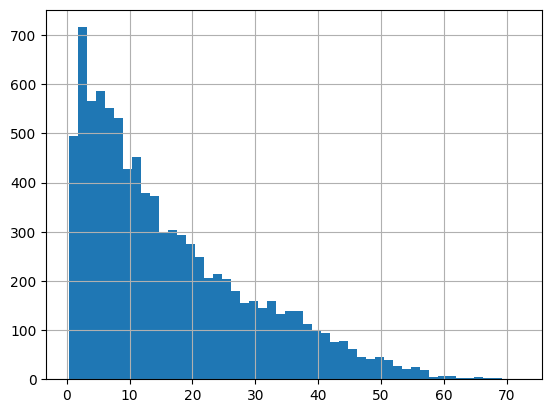

In [109]:
rec_obs[(rec_obs.ProbaFull > 0.3) & (rec_obs.Label >= 0) & (rec_obs.Cat >= 4)].groupby("AltNode").ProbaFull.sum().hist(bins=50)

<AxesSubplot:>

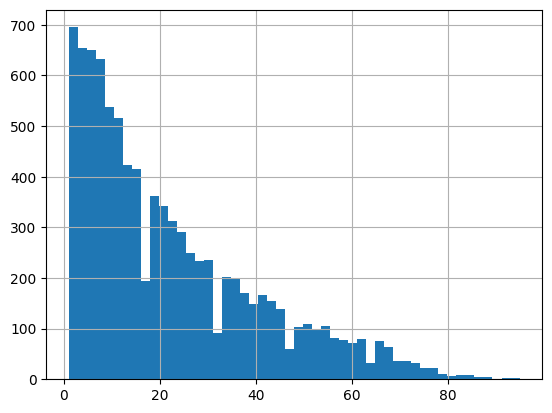

In [110]:
gt_obs[(gt_obs.Label >= 0) & (gt_obs.Cat >= 4)].groupby("AltNode").Mut.count().hist(bins=50)

### process

In [284]:
pcutoff = 0.3
cat_cutoff = 4

#prepare OBS
rec_obs_all = rec_obs[(rec_obs.ProbaFull > pcutoff) & (rec_obs.Label >= 0) & (rec_obs.Cat >= cat_cutoff)]
rec_obs_syn = rec_obs[(rec_obs.ProbaFull > pcutoff) & (rec_obs.Label >= 1) & (rec_obs.Cat >= cat_cutoff)]
gt_obs_all = gt_obs[(gt_obs.Label >= 0) & (gt_obs.Cat >= cat_cutoff)].assign(ProbaFull=1.0)
gt_obs_syn = gt_obs[(gt_obs.Label >= 1) & (gt_obs.Cat >= cat_cutoff)].assign(ProbaFull=1.0)

#prepare EXP
rec_exp_all = rec_exp[(rec_exp.Proba > pcutoff) & (rec_exp.Label.astype("category") == "all") & (rec_exp.Cat >= cat_cutoff)]
rec_exp_syn = rec_exp[(rec_exp.Proba > pcutoff) & (rec_exp.Label.astype("category") == "syn") & (rec_exp.Cat >= cat_cutoff)]
gt_exp_all = gt_exp[(gt_exp.Label.astype("category") == "all") & (gt_exp.Cat >= cat_cutoff)].assign(Proba=1.0)
gt_exp_syn = gt_exp[(gt_exp.Label.astype("category") == "syn") & (gt_exp.Cat >= cat_cutoff)].assign(Proba=1.0)

In [274]:
rec_spectra12, rec_spectra192 = calc_edgewise_spectra(rec_obs_all, rec_exp_all, 16, 20, both_12_and_192=True)
gt_spectra12, gt_spectra192 = calc_edgewise_spectra(gt_obs_all, gt_exp_all, 16, 20, both_12_and_192=True)

<AxesSubplot:>

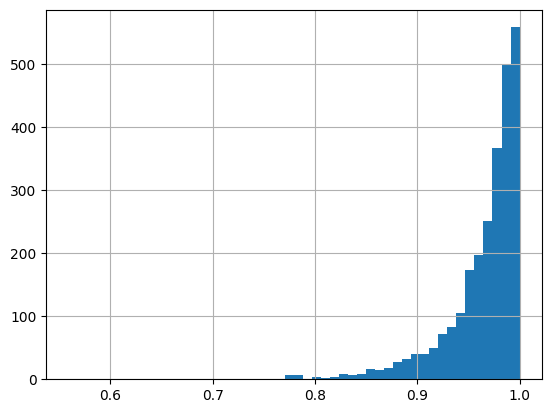

In [275]:
get_cossim(gt_spectra12, rec_spectra12).hist(bins=50)

<AxesSubplot:>

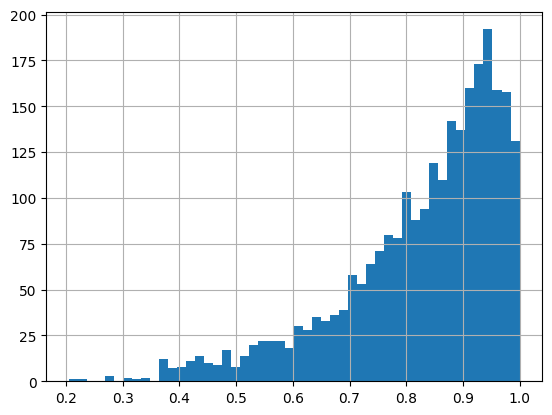

In [276]:
get_cossim(gt_spectra192, rec_spectra192).hist(bins=50)

<AxesSubplot:>

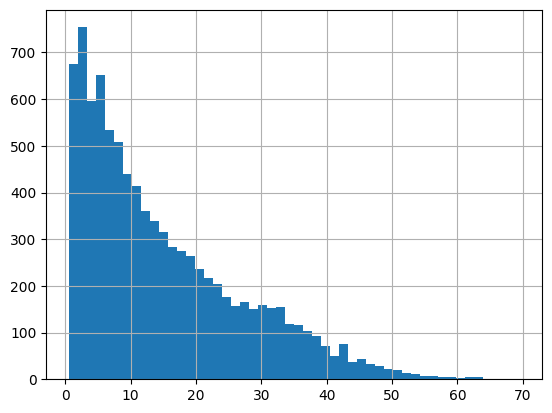

In [277]:
rec_obs_all.groupby("AltNode").ProbaFull.sum().hist(bins=50)

In [278]:
rec_spectra12, rec_spectra192 = calc_edgewise_spectra(rec_obs_syn, rec_exp_syn, 2, 1, both_12_and_192=True)
gt_spectra12, gt_spectra192 = calc_edgewise_spectra(gt_obs_syn, gt_exp_syn, 2, 1, both_12_and_192=True)

<AxesSubplot:>

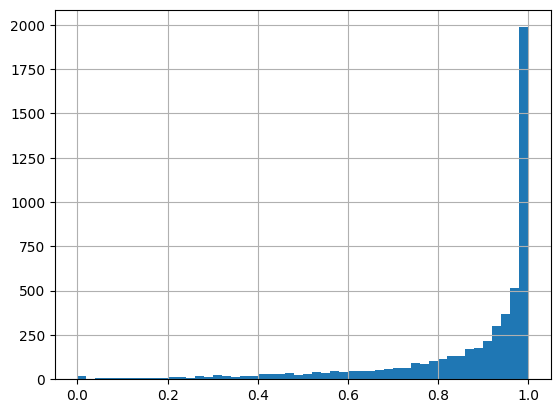

In [279]:
get_cossim(gt_spectra12, rec_spectra12).hist(bins=50)

<AxesSubplot:>

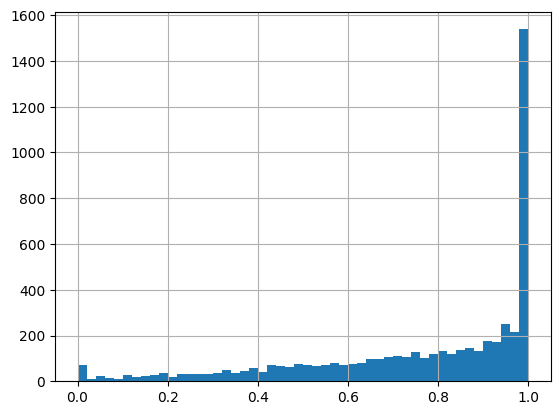

In [280]:
get_cossim(gt_spectra192, rec_spectra192).hist(bins=50)

In [310]:
#calc tree spectra
rec_all_spectra12, rec_all_spectra192 = calc_edgewise_spectra(rec_obs_all, rec_exp_all, 0, 0, both_12_and_192=True)
gt_all_spectra12, gt_all_spectra192   = calc_edgewise_spectra(gt_obs_all, gt_exp_all, 0, 0, both_12_and_192=True)
rec_syn_spectra12, rec_syn_spectra192 = calc_edgewise_spectra(rec_obs_syn, rec_exp_syn, 0, 0, both_12_and_192=True)
gt_syn_spectra12, gt_syn_spectra192   = calc_edgewise_spectra(gt_obs_syn, gt_exp_syn, 0, 0, both_12_and_192=True)

#get cossim
cossim12_all  = get_cossim(gt_all_spectra12,  rec_all_spectra12).rename("cossim12_all").reset_index()
cossim192_all = get_cossim(gt_all_spectra192, rec_all_spectra192).rename("cossim192_all").reset_index()
cossim12_syn  = get_cossim(gt_syn_spectra12,  rec_syn_spectra12).rename("cossim12_syn").reset_index()
cossim192_syn = get_cossim(gt_syn_spectra192, rec_syn_spectra192).rename("cossim192_syn").reset_index()

In [309]:
cossim12_all.shape, cossim12_syn.shape, cossim192_all.shape, cossim192_syn.shape

((9111,), (7484,), (9111,), (7484,))

In [316]:
cossim12_all.merge(cossim12_syn, "outer", on=["RefNode", "AltNode"])\
    .merge(cossim192_all, "outer", on=["RefNode", "AltNode"])\
        .merge(cossim192_syn, "outer", on=["RefNode", "AltNode"])

,RefNode,AltNode,cossim12_all,cossim12_syn,cossim192_all,cossim192_syn
0,Node10,Node11,0.938734,0.825650,0.753140,0.360127
1,Node10,Node40,0.885057,0.689174,0.601145,0.577881
2,Node100,Node101,0.767427,0.670762,0.818125,0.331364
3,Node100,RN_94,0.971122,0.923177,0.894590,0.841255
4,Node1000,Node1001,0.999542,1.000000,0.989377,1.000000
...,...,...,...,...,...,...
9106,Node996,RN_982,0.950551,NaN,0.931553,NaN
9107,Node997,Node998,0.999999,1.000000,0.999999,1.000000
9108,Node997,RN_981,1.000000,1.000000,1.000000,1.000000
9109,Node998,RN_980,0.986519,NaN,0.969133,NaN


#### OBS and EXP cossims

In [293]:
collapse_sbs192(rec_obs_all.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack().fillna(0)[possible_sbs192])

Mut                      A>C       A>G       A>T       C>A       C>G  \
RefNode  AltNode                                                       
Node10   Node11     8.445275  1.209684  1.055664  5.336626  0.000000   
         Node40     8.406827  1.542016  0.000000  1.886836  1.201454   
Node100  Node101    4.928405  1.633659  0.000000  0.000000  0.000000   
         RN_94     10.513337  0.000000  0.000000  9.878184  2.750651   
Node1000 Node1001   1.980697  0.992309  0.000000  5.382756  0.992110   
...                      ...       ...       ...       ...       ...   
Node996  RN_982     0.995429  0.000000  0.000000  1.985544  0.995240   
Node997  Node998    0.000000  0.000000  0.000000  0.993879  0.000000   
         RN_981     3.988031  0.000000  0.000000  0.997462  0.000000   
Node998  RN_980     0.999445  0.000000  0.000000  0.000000  0.000000   
Node999  RN_979     0.000000  0.999999  0.000000  2.999997  0.000000   

Mut                     C>T       G>A       G>C       G>T       T>A       T>C  \
RefNode  AltNode                                                                
Node10   Node11    0.584791  1.320983  0.613169  1.758684  1.124846  0.000000   
         Node40    0.000000  1.897062  0.506550  1.320667  0.885306  0.485109   
Node100  Node101   0.000000  1.768563  0.000000  0.971108  0.000000  0.000000   
         RN_94     0.000000  1.677687  1.913675  1.846345  1.889444  0.000000   
Node1000 Node1001  0.000000  0.000000  0.000000  0.990909  0.000000  0.000000   
...                     ...       ...       ...       ...       ...       ...   
Node996  RN_982    0.000000  0.000000  0.000000  0.996387  0.000000  0.000000   
Node997  Node998   0.000000  0.000000  0.997033  0.000000  0.997572  0.000000   
         RN_981    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Node998  RN_980    0.000000  0.000000  0.520033  0.000000  0.000000  0.000000   
Node999  RN_979    0.000000  0.999999  0.000000  0.000000  0.000000  0.000000   

Mut                     T>G  
RefNode  AltNode             
Node10   Node11    2.911396  
         Node40    1.716361  
Node100  Node101   1.500109  
         RN_94     4.707890  
Node1000 Node1001  0.000000  
...                     ...  
Node996  RN_982    0.000000  
Node997  Node998   0.000000  
         RN_981    0.000000  
Node998  RN_980    1.998500  
Node999  RN_979    0.000000  

[9149 rows x 12 columns]

Text(0.5, 1.0, 'distribution of cossim of OBSERVED: reconstructed VS ground truth')

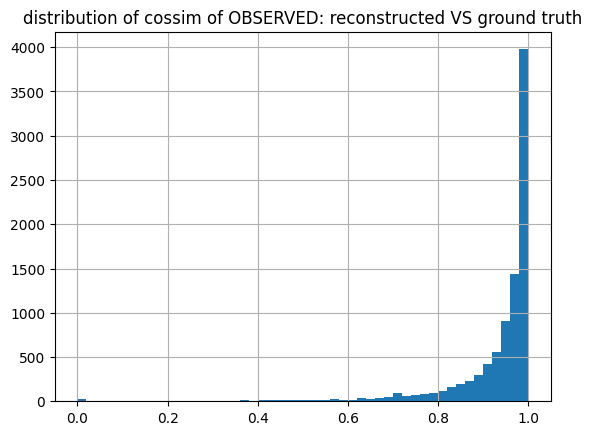

In [294]:
get_cossim(
    collapse_sbs192(rec_obs_all.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack().fillna(0)[possible_sbs192]),
    collapse_sbs192(gt_obs_all.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack().fillna(0)[possible_sbs192]),
).hist(bins=50)
plt.title("distribution of cossim of OBSERVED: reconstructed VS ground truth 12 comp")

Text(0.5, 1.0, 'distribution of cossim of EXPECTED: reconstructed VS ground truth 12 comp')

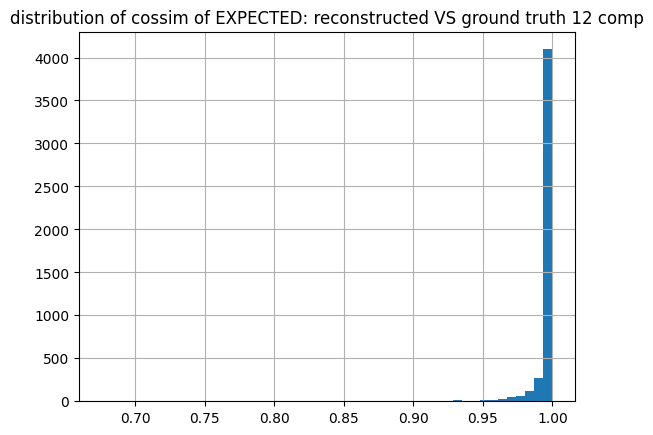

In [295]:
get_cossim(
    collapse_sbs192(rec_exp_all.groupby(["Node", "Mut"]).Proba.sum().unstack().fillna(0)[possible_sbs192]),
    collapse_sbs192(gt_exp_all.groupby(["Node", "Mut"]).Proba.sum().unstack().fillna(0)[possible_sbs192]),
).hist(bins=50)
plt.title("distribution of cossim of EXPECTED: reconstructed VS ground truth 12 comp")

Text(0.5, 1.0, 'distribution of cossim of OBSERVED: reconstructed VS ground truth 192 comp')

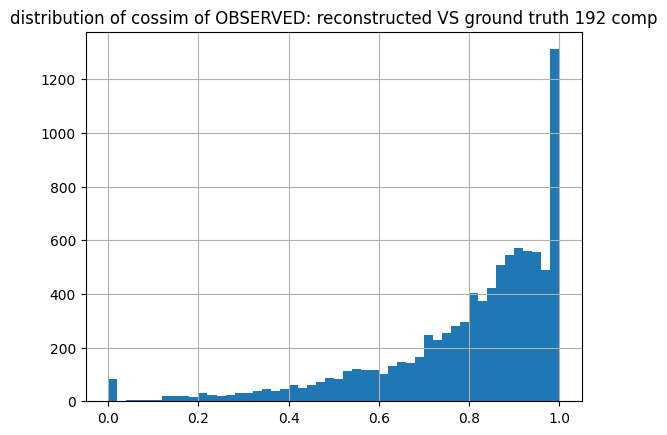

In [296]:
get_cossim(
    rec_obs_all.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack(),
    gt_obs_all.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack(),
).hist(bins=50)
plt.title("distribution of cossim of OBSERVED: reconstructed VS ground truth 192 comp")

Text(0.5, 1.0, 'distribution of cossim of EXPECTED: reconstructed VS ground truth 192 comp')

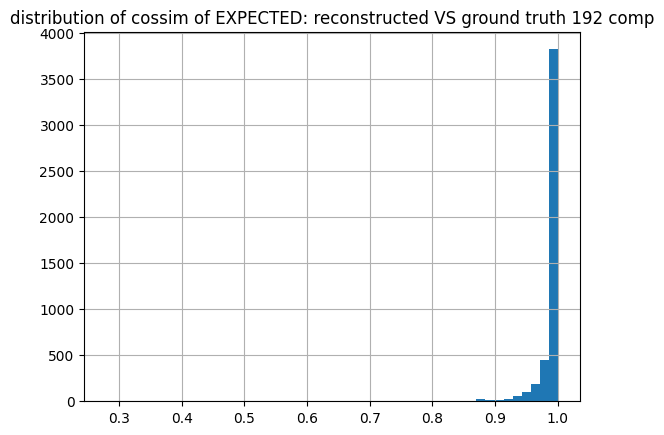

In [297]:
get_cossim(
    rec_exp_all.groupby(["Node", "Mut"]).Proba.sum().unstack(),
    gt_exp_all.groupby(["Node", "Mut"]).Proba.sum().unstack(),
).hist(bins=50)
plt.title("distribution of cossim of EXPECTED: reconstructed VS ground truth 192 comp")

### Legacy

In [6]:
gt12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2260233 entries, 0 to 71510
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Mut      object 
 1   ObsNum   float32
 2   ExpNum   float32
 3   MutSpec  float32
 4   AltNode  object 
 5   Label    object 
 6   RawCond  object 
dtypes: float32(3), object(4)
memory usage: 112.1+ MB


In [7]:
gt192.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5803177 entries, 0 to 201547
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Mut      object 
 1   ObsNum   float32
 2   ExpNum   float32
 3   MutSpec  float32
 4   AltNode  object 
 5   Label    object 
 6   RawCond  object 
dtypes: float32(3), object(4)
memory usage: 287.8+ MB


In [11]:
#filter out low numbers of mutations
rec12 = rec12[(rec12.ObsNum >= 1) & (rec12.ExpNum >= 1)]
rec192 = rec192[(rec192.ObsNum >= 1) & (rec192.ExpNum >= 1)]

### Compare spectra

In [18]:
gt12

,Mut,ObsNum,ExpNum,MutSpec,AltNode,Label,RawCond
0,A>C,10.0,325.0,0.107685,OUTGRP,all,gtr_mam_cytb_replica_18
1,A>G,8.0,325.0,0.086148,OUTGRP,all,gtr_mam_cytb_replica_18
2,A>T,5.0,325.0,0.053842,OUTGRP,all,gtr_mam_cytb_replica_18
3,C>A,26.0,390.0,0.233318,OUTGRP,all,gtr_mam_cytb_replica_18
4,C>G,8.0,390.0,0.071790,OUTGRP,all,gtr_mam_cytb_replica_18
...,...,...,...,...,...,...,...
71506,T>G,1.0,21.0,1.000000,RN_1803,syn,gtr_mam_cytb_replica_15
71507,A>T,1.0,349.0,1.000000,RN_2991,all,gtr_mam_cytb_replica_15
71508,A>T,1.0,78.0,1.000000,RN_2991,syn,gtr_mam_cytb_replica_15
71509,G>T,1.0,190.0,1.000000,RN_2992,all,gtr_mam_cytb_replica_15


In [12]:
gt12_wide_spectra = gt12.set_index(["RawCond", "Label", "AltNode", "Mut"]).MutSpec.unstack()
rec12_wide_spectra = rec12.set_index(["RawCond", "Label", "AltNode", "Mut"]).MutSpec.unstack().fillna(0.)
gt192_wide_spectra = gt192.set_index(["RawCond", "Label", "AltNode", "Mut"]).MutSpec.unstack()
rec192_wide_spectra = rec192.set_index(["RawCond", "Label", "AltNode", "Mut"]).MutSpec.unstack().fillna(0.)

In [13]:
cossim12 = get_cossim(gt12_wide_spectra, rec12_wide_spectra).rename("CosSim12").reset_index()
cossim12["mdl"] = cossim12.RawCond.apply(lambda x: x.split("_")[0])
cossim12["seq"] = cossim12.RawCond.apply(lambda x: x.split("_")[2])
cossim12["replica"] = cossim12.RawCond.apply(lambda x: x.split("_")[-1])

cossim192 = get_cossim(gt192_wide_spectra, rec192_wide_spectra).rename("CosSim192").reset_index()
cossim192["mdl"] = cossim192.RawCond.apply(lambda x: x.split("_")[0])
cossim192["seq"] = cossim192.RawCond.apply(lambda x: x.split("_")[2])
cossim192["replica"] = cossim192.RawCond.apply(lambda x: x.split("_")[-1])

cossim12

,RawCond,Label,AltNode,CosSim12,mdl,seq,replica
0,12.12_mam_cytb_replica_12,all,Node10,0.368621,12.12,cytb,12
1,12.12_mam_cytb_replica_12,all,Node100,0.967257,12.12,cytb,12
2,12.12_mam_cytb_replica_12,all,Node1001,0.970936,12.12,cytb,12
3,12.12_mam_cytb_replica_12,all,Node1003,0.588948,12.12,cytb,12
4,12.12_mam_cytb_replica_12,all,Node1004,0.931542,12.12,cytb,12
...,...,...,...,...,...,...,...
312424,gtr_mam_rnd_replica_44,syn,RN_995,0.786440,gtr,rnd,44
312425,gtr_mam_rnd_replica_44,syn,RN_996,0.453915,gtr,rnd,44
312426,gtr_mam_rnd_replica_44,syn,RN_997,0.897822,gtr,rnd,44
312427,gtr_mam_rnd_replica_44,syn,RN_998,0.933428,gtr,rnd,44


In [14]:
# cossim12.iloc[:, :-3].to_csv("../data/alisim/mam_cossim12.csv", index=False)
# cossim192.iloc[:, :-3].to_csv("../data/alisim/mam_cossim192.csv", index=False)

#### Plot

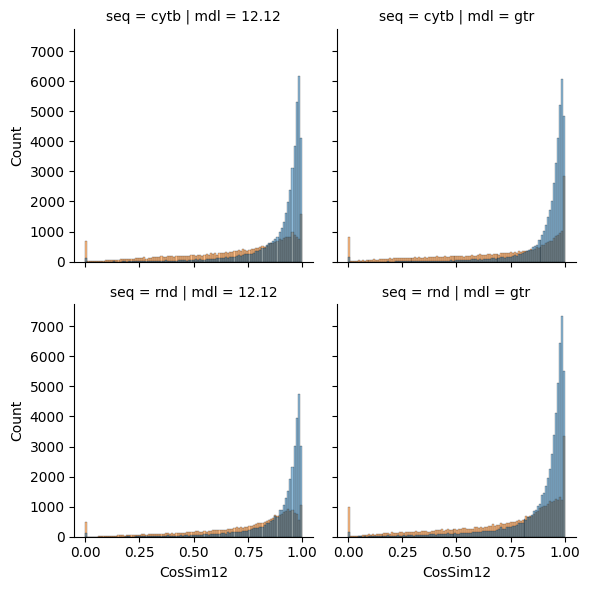

In [15]:
g = sns.FacetGrid(cossim12, col="mdl", row="seq")
g.map_dataframe(sns.histplot, x="CosSim12", hue="Label")

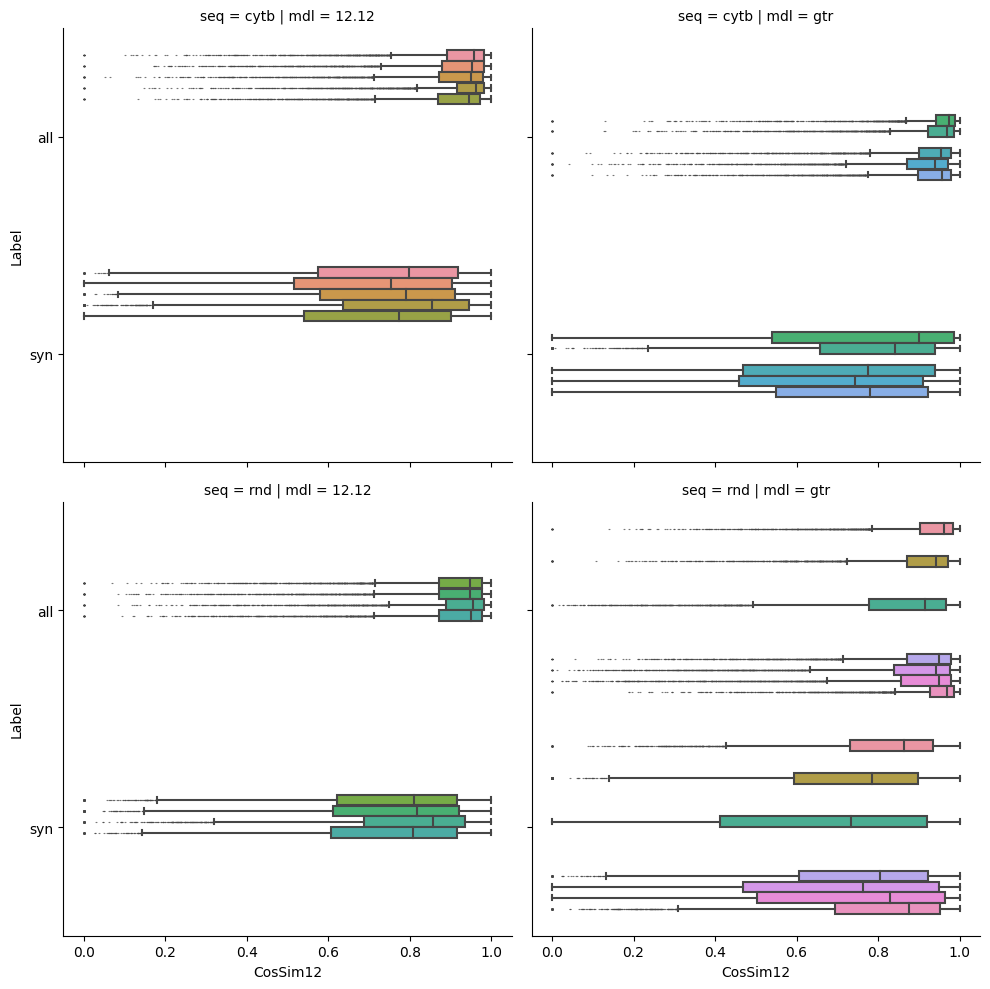

In [16]:
g = sns.catplot(
    data=cossim12, x="CosSim12", hue="replica", y="Label", col="mdl", row="seq", 
    kind="box", fliersize=0.2, legend=False)

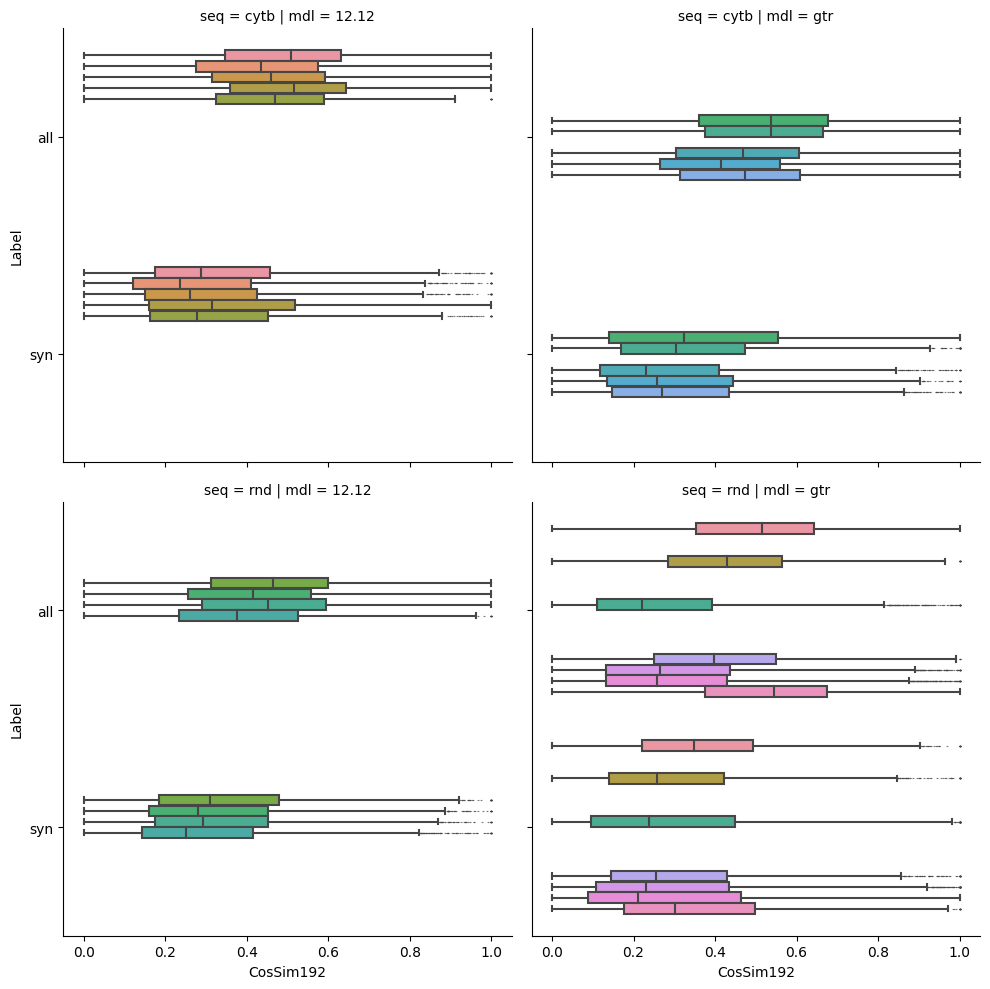

In [17]:
g = sns.catplot(
    data=cossim192, x="CosSim192", hue="replica", y="Label", col="mdl", row="seq", 
    kind="box", fliersize=0.2, legend=False)

In [ ]:
# filter out edges with less than 16/4 mut types
gt12_wide_spectra_filtered  = gt12_wide_spectra[ (gt12_wide_spectra > 0).sum(axis=1)  >= 4]
gt192_wide_spectra_filtered = gt192_wide_spectra[(gt192_wide_spectra > 0).sum(axis=1) >= 16]
rec12_wide_spectra_filtered  = rec12_wide_spectra[ (rec12_wide_spectra > 0).sum(axis=1)  >= 4]
rec192_wide_spectra_filtered = rec192_wide_spectra[(rec192_wide_spectra > 0).sum(axis=1) >= 16]

In [36]:
cossim12_filtered = get_cossim(gt12_wide_spectra_filtered, rec12_wide_spectra_filtered).rename("CosSim12").reset_index()
cossim12_filtered["mdl"] = cossim12_filtered.RawCond.apply(lambda x: x.split("_")[0])
cossim12_filtered["seq"] = cossim12_filtered.RawCond.apply(lambda x: x.split("_")[2])
cossim12_filtered["replica"] = cossim12_filtered.RawCond.apply(lambda x: x.split("_")[-1])

cossim192_filtered = get_cossim(gt192_wide_spectra_filtered, rec192_wide_spectra_filtered).rename("CosSim192").reset_index()
cossim192_filtered["mdl"] = cossim192_filtered.RawCond.apply(lambda x: x.split("_")[0])
cossim192_filtered["seq"] = cossim192_filtered.RawCond.apply(lambda x: x.split("_")[2])
cossim192_filtered["replica"] = cossim192_filtered.RawCond.apply(lambda x: x.split("_")[-1])

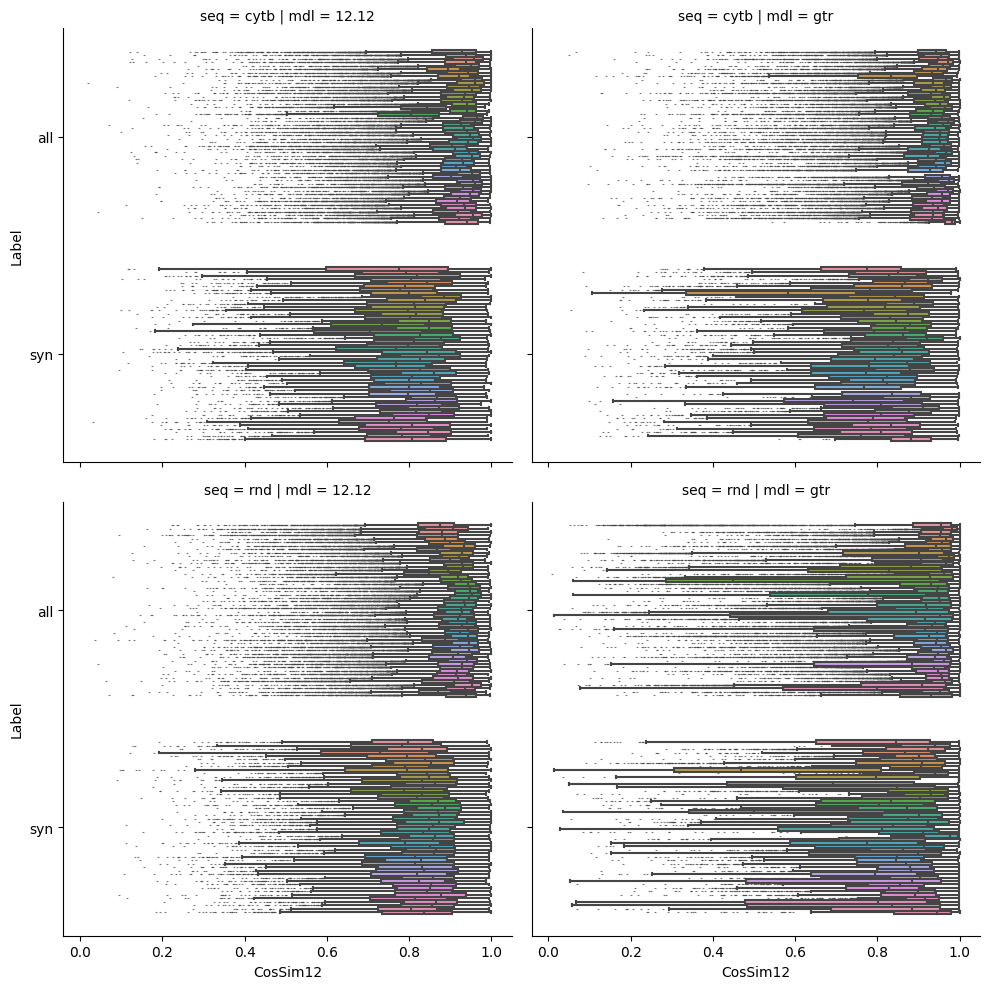

In [37]:
g = sns.catplot(
    data=cossim12_filtered, x="CosSim12", hue="replica", y="Label", col="mdl", row="seq", 
    kind="box", fliersize=0.2, legend=False)

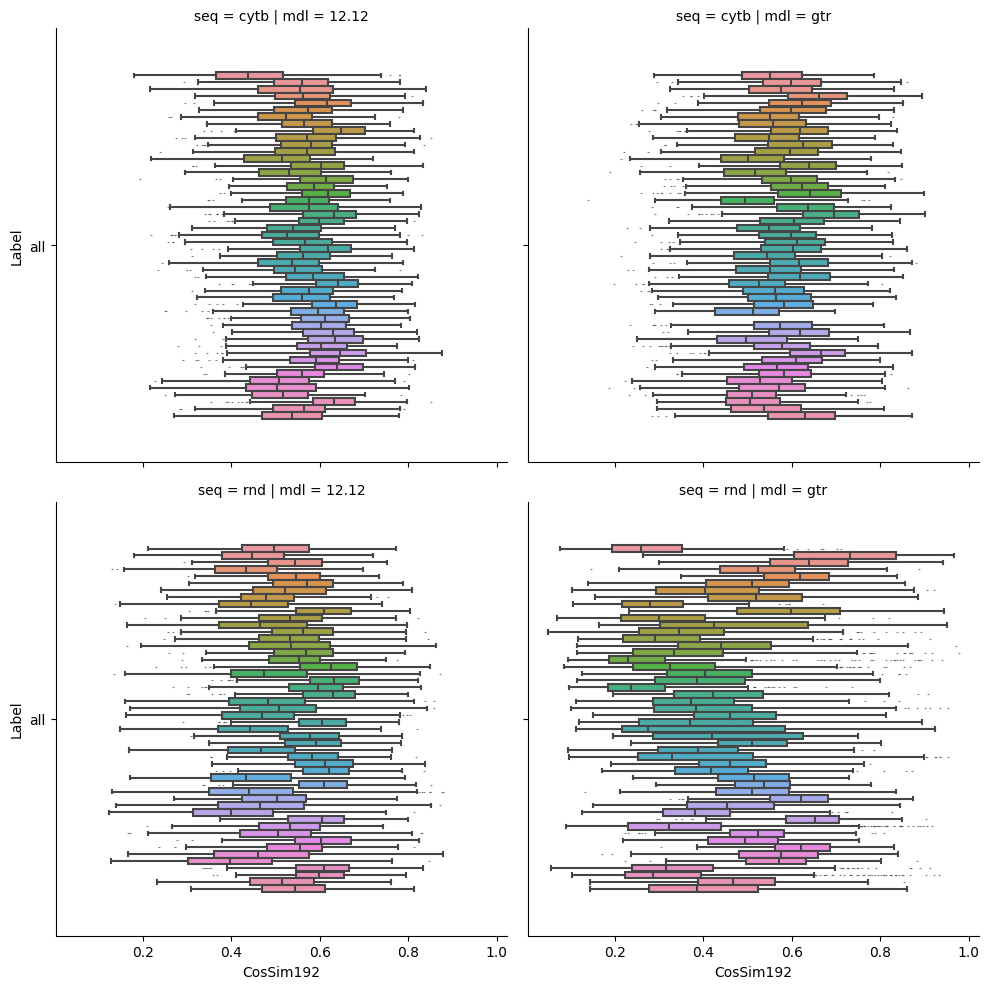

In [38]:
g = sns.catplot(
    data=cossim192_filtered, x="CosSim192", hue="replica", y="Label", col="mdl", row="seq", 
    kind="box", fliersize=0.2, legend=False)

#### Compare OBS

In [50]:
gt12_wide_obs = gt12.set_index(["RawCond", "Label", "AltNode", "Mut"]).ObsNum.unstack()
rec12_wide_obs = rec12.set_index(["RawCond", "Label", "AltNode", "Mut"]).ObsNum.unstack()
gt192_wide_obs = gt192.set_index(["RawCond", "Label", "AltNode", "Mut"]).ObsNum.unstack()
rec192_wide_obs = rec192.set_index(["RawCond", "Label", "AltNode", "Mut"]).ObsNum.unstack()

In [51]:
# filter out edges with less than 16/4 mut types
gt12_wide_obs_filtered  = gt12_wide_obs[ (gt12_wide_obs > 0).sum(axis=1)  >= 4]
gt192_wide_obs_filtered = gt192_wide_obs[(gt192_wide_obs > 0).sum(axis=1) >= 16]
rec12_wide_obs_filtered  = rec12_wide_obs[ (rec12_wide_obs > 0).sum(axis=1)  >= 4]
rec192_wide_obs_filtered = rec192_wide_obs[(rec192_wide_obs > 0).sum(axis=1) >= 16]

In [52]:
cossim12 = get_cossim(gt12_wide_obs, rec12_wide_obs).rename("CosSim12").reset_index()
cossim192 = get_cossim(gt192_wide_obs, rec192_wide_obs).rename("CosSim192").reset_index()

cossim12["mdl"] = cossim12.RawCond.apply(lambda x: x.split("_")[0])
cossim12["seq"] = cossim12.RawCond.apply(lambda x: x.split("_")[2])
cossim12["replica"] = cossim12.RawCond.apply(lambda x: x.split("_")[-1])

cossim192["mdl"] = cossim192.RawCond.apply(lambda x: x.split("_")[0])
cossim192["seq"] = cossim192.RawCond.apply(lambda x: x.split("_")[2])
cossim192["replica"] = cossim192.RawCond.apply(lambda x: x.split("_")[-1])

cossim12

,RawCond,Label,AltNode,CosSim12,mdl,seq,replica
0,12.12_mam_cytb_replica_0,all,Node10,0.499527,12.12,cytb,0
1,12.12_mam_cytb_replica_0,all,Node100,0.935969,12.12,cytb,0
2,12.12_mam_cytb_replica_0,all,Node1001,0.966555,12.12,cytb,0
3,12.12_mam_cytb_replica_0,all,Node1002,0.798830,12.12,cytb,0
4,12.12_mam_cytb_replica_0,all,Node1003,0.447214,12.12,cytb,0
...,...,...,...,...,...,...,...
2761887,gtr_mam_rnd_replica_9,syn,RN_995,0.948759,gtr,rnd,9
2761888,gtr_mam_rnd_replica_9,syn,RN_996,0.999292,gtr,rnd,9
2761889,gtr_mam_rnd_replica_9,syn,RN_997,0.976002,gtr,rnd,9
2761890,gtr_mam_rnd_replica_9,syn,RN_998,0.968973,gtr,rnd,9


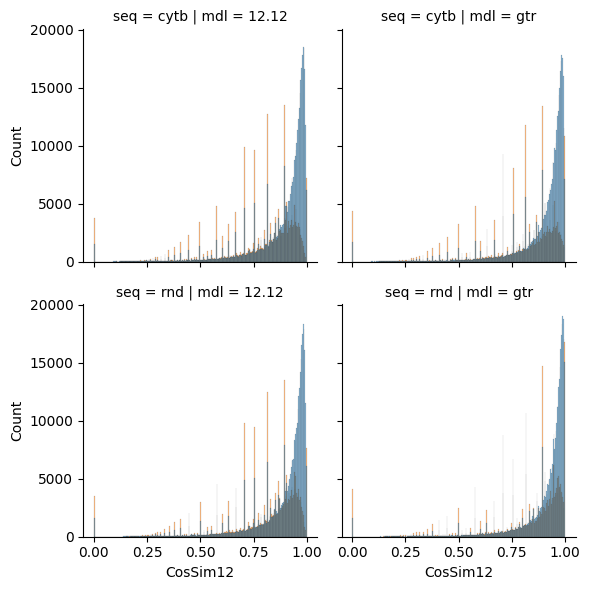

In [53]:
g = sns.FacetGrid(cossim12, col="mdl", row="seq")
g.map_dataframe(sns.histplot, x="CosSim12", hue="Label")

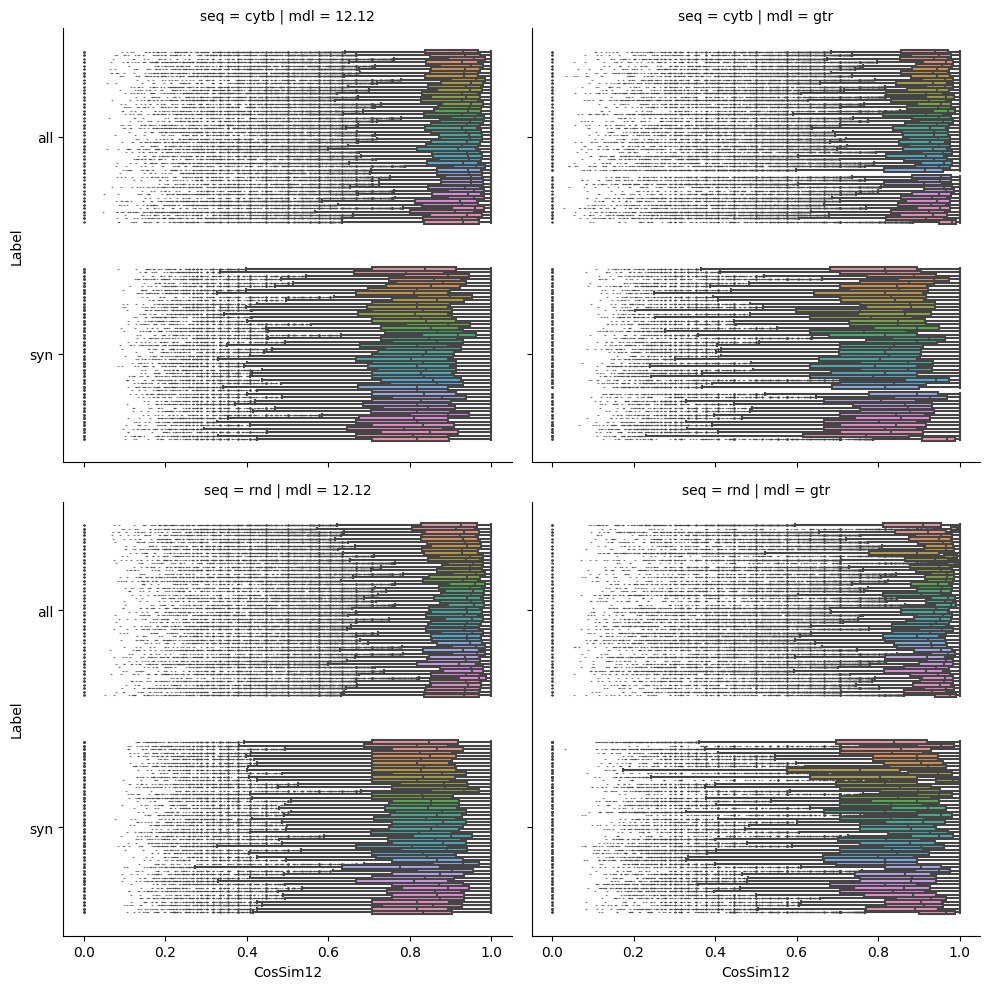

In [54]:
g = sns.catplot(data=cossim12, x="CosSim12", hue="replica", y="Label", col="mdl", row="seq", kind="box", fliersize=0.2, legend=False)

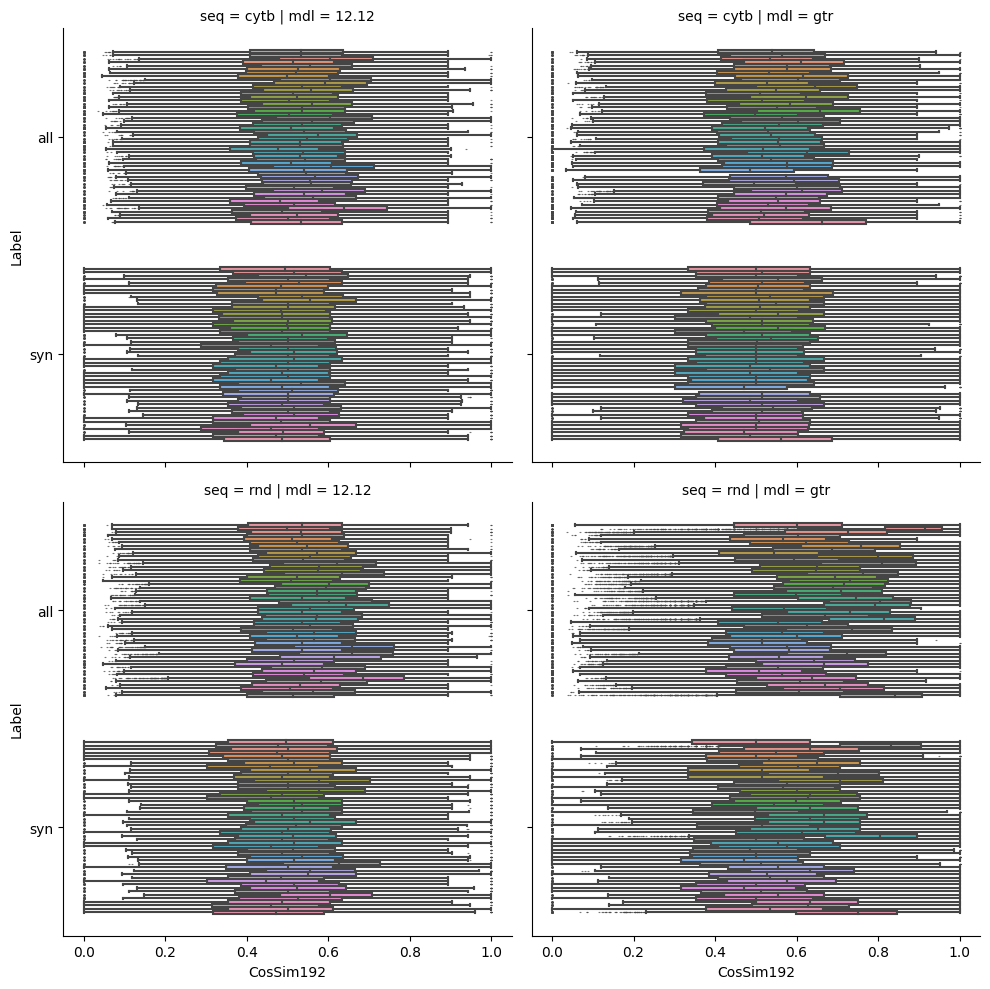

In [55]:
g = sns.catplot(data=cossim192, x="CosSim192", hue="replica", y="Label", col="mdl", row="seq", kind="box", fliersize=0.2, legend=False)

### Correlate edge cossim versus length